# Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import pretraitement

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb


In [2]:
DATA_x = pd.read_csv('data/X_train_G3tdtEn.csv', delimiter = ',',encoding = 'latin1', low_memory=False)
DATA_y = pd.read_csv('data/Y_train_2_XPXJDyy.csv', delimiter = ',',encoding = 'latin1', low_memory=False)

# Prétraitement

On choisit quelles colonnes sont gardées. Pour le moment, on garde seulement ``ID``, ``cash_price1``,``cash_price2``,``cash_price3``

In [3]:
selection_colonnes = ['ID'] + ["cash_price" + str(i) for i in range(1, 4)]
df_prices = DATA_x[selection_colonnes]
df_prices = pd.merge(df_prices, DATA_y, on='ID')
df_prices = df_prices.drop("index",axis=1)
df_prices

,ID,cash_price1,cash_price2,cash_price3,fraud_flag
0,85517,889.0,NaN,NaN,0
1,51113,409.0,NaN,NaN,0
2,83008,1399.0,NaN,NaN,0
3,78712,689.0,119.0,NaN,0
4,77846,1199.0,NaN,NaN,0
...,...,...,...,...,...
92785,21243,299.0,7.0,NaN,0
92786,45891,898.0,NaN,NaN,0
92787,42613,519.0,259.0,949.0,0
92788,43567,1099.0,2099.0,NaN,0


# Test : sous-échantillonnage de la classe majoritaire

Actuellement, les paniers frauduleux ne représentent que **1%** de la BDD. 

L'idée est donc la suivante : 
- X -> X_train (80%) et X_test(20%)
- Dans X_train, rééquilibrer les deux classes (de 99%-1% à 70%-30% par exemple)
- Dans X_test, garder le déséquilibre pour tester la robustesse de notre modèle dans les cas réels (où les fraudes représente 1%)

In [4]:
Y = df_prices[['ID','fraud_flag']] #On garde aussi l'ID au cas où on est besoin de merge des dataFrames X/Y plus tard
X = df_prices.drop("fraud_flag", axis=1)
X = X.fillna(0) #Les modeles ne gérent pas les NaN -> on les remplace par des 0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

In [5]:
X_test = X_test.drop("ID", axis=1)
Y_test = Y_test.drop("ID", axis=1)

### Statistiques

In [6]:
nb_perfect_X = df_prices[df_prices['fraud_flag'] == 0].shape[0]
nb_fraude_X = df_prices[df_prices['fraud_flag'] == 1].shape[0]
nb_perfect_train = Y_train['fraud_flag'].value_counts(normalize=False)[0]
nb_fraude_train = Y_train['fraud_flag'].value_counts(normalize=False)[1]
nb_perfect_test = Y_test['fraud_flag'].value_counts(normalize=False)[0]
nb_fraude_test = Y_test['fraud_flag'].value_counts(normalize=False)[1]

total_X = nb_perfect_X + nb_fraude_X
total_train = nb_perfect_train + nb_fraude_train
total_test = nb_perfect_test + nb_fraude_test

percent_perfect_X = round(100*nb_perfect_X/total_X, 2)
percent_fraude_X = round(100*nb_fraude_X/total_X, 2)
percent_perfect_train = round(100*nb_perfect_train/total_train, 2)
percent_fraude_train = round(100*nb_fraude_train/total_train, 2)
percent_perfect_test = round(100*nb_perfect_test/total_test, 2)
percent_fraude_test = round(100*nb_fraude_test/total_test, 2)

print("Nombre de perfect : ", nb_perfect_X, " (", percent_perfect_X, "%)")
print("Nombre de fraudes : ", nb_fraude_X, " (", percent_fraude_X, "%)")
print("Nombre de perfect dans Y_train : ", nb_perfect_train, " (", percent_perfect_train, "%)")
print("Nombre de fraudes dans Y_train : ", nb_fraude_train, " (", percent_fraude_train, "%)")
print("Nombre de perfect dans Y_test : ", nb_perfect_test, " (", percent_perfect_test, "%)")
print("Nombre de fraudes dans Y_test : ", nb_fraude_test, " (", percent_fraude_test, "%)")


Nombre de perfect :  91471  ( 98.58 %)
Nombre de fraudes :  1319  ( 1.42 %)
Nombre de perfect dans Y_train :  73185  ( 98.59 %)
Nombre de fraudes dans Y_train :  1047  ( 1.41 %)
Nombre de perfect dans Y_test :  18286  ( 98.53 %)
Nombre de fraudes dans Y_test :  272  ( 1.47 %)


### Sous-échantillonnage

In [7]:
def sous_echantillonnage(X_train, Y_train, pourcentage_fraud) : 

    XY_train = pd.merge(X_train, Y_train, on='ID')

    # Séparation des données frauduleuses et non-frauduleuses
    fraud = XY_train[XY_train['fraud_flag'] == 1]
    not_fraud = XY_train[XY_train['fraud_flag'] == 0]
    
    nb_samples = int( (100 - pourcentage_fraud) * len(fraud) / pourcentage_fraud ) 

    not_fraud_sampled = resample(not_fraud, replace=False, n_samples=nb_samples, random_state=42)

    # Concaténation des données frauduleuses et non-frauduleuses sous-échantillonnées
    data_sampled = pd.concat([fraud, not_fraud_sampled])

    # Mélange des données pour éviter les biais
    data_sampled = data_sampled.sample(frac=1, random_state=42)

    Y_train = data_sampled['fraud_flag']
    X_train = data_sampled.drop('ID',axis=1)
    X_train = X_train.drop("fraud_flag", axis=1)

    nb_perfect_sampled = data_sampled['fraud_flag'].value_counts(normalize=False)[0]
    nb_fraude_sampled = data_sampled['fraud_flag'].value_counts(normalize=False)[1]

    print("Nombre de perfect dans data_sampled : ", nb_perfect_sampled, " (", "{:.2f}".format(100 - 100*nb_fraude_sampled/(nb_perfect_sampled+nb_fraude_sampled)), "%)")
    print("Nombre de fraudes dans data_sampled : ", nb_fraude_sampled, " (", "{:.2f}".format(100*nb_fraude_sampled/(nb_perfect_sampled+nb_fraude_sampled)), "%)")

    return X_train, Y_train

In [8]:
X_train_bis, Y_train_bis = sous_echantillonnage(X_train,Y_train,2)

Nombre de perfect dans data_sampled :  51303  ( 98.00 %)
Nombre de fraudes dans data_sampled :  1047  ( 2.00 %)


# Test de modèles

In [9]:
def test_modeles(X_train_bis, Y_train_bis, X_test, Y_test):
    model1 = RandomForestClassifier(n_estimators=150, random_state=42)
    model2 = xgb.XGBClassifier()
    model3 = LogisticRegression()

    model1.fit(X_train_bis, Y_train_bis)
    model2.fit(X_train_bis, Y_train_bis)
    model3.fit(X_train_bis, Y_train_bis)

    y_pred1 = model1.predict(X_test)
    y_pred2 = model2.predict(X_test)
    y_pred3 = model3.predict(X_test)

    average_precision1 = average_precision_score(Y_test, y_pred1)
    average_precision2 = average_precision_score(Y_test, y_pred2)
    average_precision3 = average_precision_score(Y_test, y_pred3)

    print("Random Forest, average_precision : ", average_precision1)
    print("XGB booster average_precision :", average_precision2)
    print("logistic average_precision :", average_precision3)


    return average_precision1, average_precision2, average_precision3

On va tester pour plusieurs valeurs de rééquilibrages de la BDD de train

In [10]:
valeurs = []
for i in [2]:
    X_train_bis, Y_train_bis = sous_echantillonnage(X_train,Y_train,i)
    av1, av2, av3= test_modeles(X_train_bis,Y_train_bis,X_test,Y_test)
    valeurs.append((av1,av2,av3))

print(valeurs)

Nombre de perfect dans data_sampled :  51303  ( 98.00 %)
Nombre de fraudes dans data_sampled :  1047  ( 2.00 %)
Random Forest, average_precision :  0.051866182795605974
XGB booster average_precision : 0.043926869972043134
logistic average_precision : 0.014656751805151417
[(0.051866182795605974, 0.043926869972043134, 0.014656751805151417)]


In [ ]:
i = [2,5,10,20,30,40,50]
plt.plot(i, [x[0] for x in valeurs], label='Random Forest')
plt.plot(i, [x[1] for x in valeurs], label='XGB Booster')
plt.plot(i, [x[2] for x in valeurs], label='Logistic regression')
plt.xlabel('Pourcentage de répartition fraude')
plt.ylabel('Précision')
plt.title('Courbes de précision')
plt.legend()
plt.show()

# Et si on essayait le sous-échantillonnage sur les marques ? 

---

### à ignorer : je regarde si un nombre importants d'items à un lien avec la fraude ou non 

In [32]:
merged_df = pd.merge(DATA_x,DATA_y,on="ID")
merged_df_fraud = merged_df[merged_df["fraud_flag"] == 1]

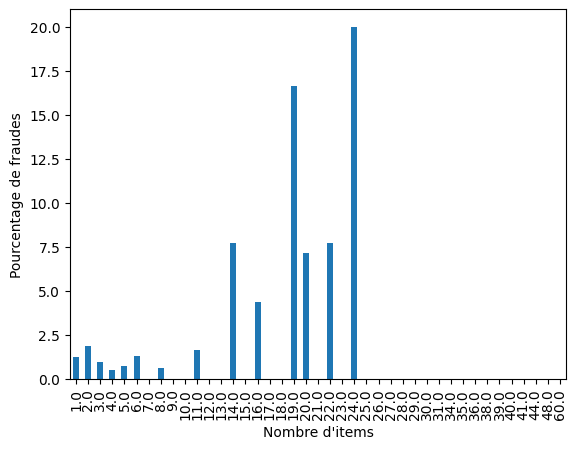

In [52]:
total_counts = merged_df['Nb_of_items'].value_counts()
fraud_counts = merged_df_fraud['Nb_of_items'].value_counts()
fraud_percentages = fraud_counts / total_counts * 100

fraud_percentages.plot(kind='bar')
plt.xlabel('Nombre d\'items')
plt.ylabel('Pourcentage de fraudes')
plt.show()

In [63]:
nb_fraudes = 0
nb_achats = 0
for i in [6,8,11,14,16,19,20,22,24]:
    nb_fraudes += merged_df_fraud['Nb_of_items'].value_counts()[i]
    nb_achats += merged_df['Nb_of_items'].value_counts()[i]
    print("     Nombre d'items : ", i, " / nombre d'achats : ", nb_achats, " / nombre de fraudes", nb_fraudes)

     Nombre d'items :  6  / nombre d'achats :  390  / nombre de fraudes 5
     Nombre d'items :  8  / nombre d'achats :  549  / nombre de fraudes 6
     Nombre d'items :  11  / nombre d'achats :  611  / nombre de fraudes 7
     Nombre d'items :  14  / nombre d'achats :  637  / nombre de fraudes 9
     Nombre d'items :  16  / nombre d'achats :  660  / nombre de fraudes 10
     Nombre d'items :  19  / nombre d'achats :  672  / nombre de fraudes 12
     Nombre d'items :  20  / nombre d'achats :  686  / nombre de fraudes 13
     Nombre d'items :  22  / nombre d'achats :  699  / nombre de fraudes 14
     Nombre d'items :  24  / nombre d'achats :  704  / nombre de fraudes 15


In [64]:
total = nb_achats + nb_fraudes
print("Pourcentage fraude/achat = ", 100*nb_fraudes/total)

Pourcentage fraude/achat =  2.086230876216968


In [65]:
nb_fraudes = 0
nb_achats = 0
for i in [1,2,3,4,5]:
    nb_fraudes += merged_df_fraud['Nb_of_items'].value_counts()[i]
    nb_achats += merged_df['Nb_of_items'].value_counts()[i]
    print("     Nombre d'items : ", i, " / nombre d'achats : ", nb_achats, " / nombre de fraudes", nb_fraudes)
total = nb_achats + nb_fraudes
print("Pourcentage fraude/achat = ", 100*nb_fraudes/total)

     Nombre d'items :  1  / nombre d'achats :  48134  / nombre de fraudes 611
     Nombre d'items :  2  / nombre d'achats :  79889  / nombre de fraudes 1205
     Nombre d'items :  3  / nombre d'achats :  88228  / nombre de fraudes 1286
     Nombre d'items :  4  / nombre d'achats :  90620  / nombre de fraudes 1298
     Nombre d'items :  5  / nombre d'achats :  91454  / nombre de fraudes 1304
Pourcentage fraude/achat =  1.4058086634036957


---

On créé un dataFrame avec les marques qui apparaissent dans les 4premiers items + les prix des 4premiers items + nbitems 

In [ ]:
# marques = []
# nb_colonnes = 4
# for i in range(1, nb_colonnes+1):
#     marques.append(DATA_x['make'+str(i)].astype(str).unique())

# tableau_des_marques = np.unique(np.concatenate(marques))
# col = tableau_des_marques
# df_make = pd.DataFrame(columns=col, index=DATA_x.index)
# df_make['ID'] = DATA_x['ID']

# for row in DATA_x.index:
#     for i in range(1, nb_colonnes+1):
#         marque = DATA_x[f'make{i}'][row]
#         nb_items = DATA_x[f"Nbr_of_prod_purchas{i}"][row]

#         if type(marque) == float: # Stop si valeur nulle
#             break
    
#         make_column = f"{marque}"
#         if make_column in df_make.columns:
#             df_make[make_column][row] = nb_items
# # Rajout de la colonne "Nb_of_items" 
# df_make['Nb_of_items'] = DATA_x['Nb_of_items']
# # Rajoute les colonnes "cash_price1", "cash_price2", "cash_price3"
# cash_price_columns = ["cash_price" + str(i) for i in range(1, 5)]
# X_cash_price = DATA_x[cash_price_columns]
# df_make = pd.concat([df_make, X_cash_price], axis=1)
# # Dans le doute où le modèle ne sait pas gérer les NaN et les cases vides, on remplace par des 0.
# df_make = df_make.fillna(0)
# df_make = df_make.drop("nan",axis=1)

On peut utiliser une sauvegarde pour ne pas avoir à regénérer le dataframe (~1min40). Attention : dans ce cas, une nouvelle colonne "Unnamed: 0" est présente. Il faut alors penser à l'enlever.

In [60]:
df_make = pd.read_csv('data/df_make_save.csv', delimiter = ',',encoding = 'latin1')
df_make = df_make.drop("Unnamed: 0", axis=1)

In [61]:
merged = pd.merge(df_make,DATA_y,on="ID")

In [62]:
Y = merged[['ID','fraud_flag']] #On garde aussi l'ID au cas où on est besoin de merge des dataFrames X/Y plus tard
X = merged.drop("fraud_flag", axis=1)
X = X.fillna(0) #Les modeles ne gérent pas les NaN -> on les remplace par des 0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
X_test = X_test.drop("ID", axis=1)
X_test = X_test.drop("index",axis=1)
Y_test = Y_test.drop("ID", axis=1)

In [69]:
X_train_bis = X_train.drop("ID", axis=1)
X_train_bis = X_train_bis.drop("index",axis=1)
Y_train = Y_train.drop("ID",axis=1)


In [70]:
Y_train

,fraud_flag
12214,0
21619,0
18886,0
85690,1
30417,0
...,...
6265,0
54886,0
76820,0
860,0


In [71]:
boost = xgb.XGBClassifier()
boost.fit(X_train_bis, Y_train)
y_pred2 = boost.predict(X_test)

average_precision2 = average_precision_score(Y_test, y_pred2)
print("XGB booster average_precision :", average_precision2)


XGB booster average_precision : 0.05624070481732946
